 
**In this project, we will build a Regression ML model based on Gradient Boosting Trees to predict the power output of a Wind Turbine.**

**Evaluation metrics:**

* R-square value
* RMSE





In [1]:
''' Installing Spark
Install Dependencies:

 1. Java 8
 2. Apache Spark with hadoop and
 3. Findspark (used to locate the spark in the system)
'''

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

# Set Environment Variables:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [89]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format
sns.set_style('darkgrid')

In [90]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [91]:
# Load the data into a spark dataframe
df = spark.read.csv('Data/Turbine_power_data.csv', header = True, inferSchema = True)
df.show(10, truncate = False)

+----------------+-------------------+----------------+-----------------------------+------------------+
|Date/Time       |LV ActivePower (kW)|Wind Speed (m/s)|Theoretical_Power_Curve (KWh)|Wind Direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|380.047790527343   |5.31133604049682|416.328907824861             |259.994903564453  |
|01 01 2018 00:10|453.76919555664    |5.67216682434082|519.917511061494             |268.64111328125   |
|01 01 2018 00:20|306.376586914062   |5.21603679656982|390.900015810951             |272.564788818359  |
|01 01 2018 00:30|419.645904541015   |5.65967416763305|516.127568975674             |271.258087158203  |
|01 01 2018 00:40|380.650695800781   |5.57794094085693|491.702971953588             |265.674285888671  |
|01 01 2018 00:50|402.391998291015   |5.60405206680297|499.436385024805             |264.57861328125   |
|01 01 2018 01:00|447.605712890625   |5.79300785064697|

In [92]:
# data types of columns
df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- LV ActivePower (kW): double (nullable = true)
 |-- Wind Speed (m/s): double (nullable = true)
 |-- Theoretical_Power_Curve (KWh): double (nullable = true)
 |-- Wind Direction (°): double (nullable = true)



In [93]:
# number of records in the dataset
df.count()

50530

In [94]:
# caching the dataset
df.cache()

Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
01 01 2018 00:00,380.047790527343,5.31133604049682,416.328907824861,259.994903564453
01 01 2018 00:10,453.76919555664,5.67216682434082,519.917511061494,268.64111328125
01 01 2018 00:20,306.376586914062,5.21603679656982,390.900015810951,272.564788818359
01 01 2018 00:30,419.645904541015,5.65967416763305,516.127568975674,271.258087158203
01 01 2018 00:40,380.650695800781,5.57794094085693,491.702971953588,265.674285888671
01 01 2018 00:50,402.391998291015,5.60405206680297,499.436385024805,264.57861328125
01 01 2018 01:00,447.605712890625,5.79300785064697,557.372363290225,266.163604736328
01 01 2018 01:10,387.2421875,5.30604982376098,414.898178826186,257.949493408203
01 01 2018 01:20,463.651214599609,5.58462905883789,493.677652137077,253.480697631835
01 01 2018 01:30,439.725708007812,5.52322816848754,475.706782818068,258.72378540039


In [95]:
from pyspark.sql.functions import col
# Statistical summary
percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
df.select(col('wind speed (m/s)'), col('theoretical_power_curve (kwh)'), col('lv activepower (kw)')) \
                                                    .toPandas().describe(percentiles = percentiles).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
wind speed (m/s),50530.00,7.56,4.23,0.00,0.81,2.37,4.20,7.10,10.30,13.20,19.21,25.21
theoretical_power_curve (kwh),50530.00,1492.18,1368.02,0.00,0.00,0.00,161.33,1063.78,2964.97,3600.00,3600.00,3600.00
lv activepower (kw),50530.00,1307.68,1312.46,-2.47,0.00,0.00,50.68,825.84,2482.51,3514.22,3603.58,3618.73




*   Some records show negative power generation (< 1%)
*   Maximum wind speed recorded is 25.21 m/s



In [96]:
# Observation with negative power generation
df.filter(df['lv activepower (kw)'] < 0).toPandas().describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,57.00,57.00,57.00,57.00
mean,-0.33,2.81,12.86,158.63
std,0.40,0.44,36.39,84.84
min,-2.47,1.97,0.00,7.08
25%,-0.46,2.57,0.00,92.27
50%,-0.17,2.73,0.00,137.31
75%,-0.10,3.05,17.69,238.41
max,-0.00,4.59,241.60,330.00


In [97]:
# Missing values check
def missing_values(df):
    missing = pd.DataFrame()
    missing['Feature'] = df.isna().sum().sort_values(ascending = False).index
    missing['Count of missing values'] = df.isna().sum().sort_values(ascending = False).to_numpy()
    missing['Percentage of Total'] = df.isna().sum().sort_values(ascending = False).to_numpy()/len(df)*100
    return missing

missing_values(df.toPandas())

,Feature,Count of missing values,Percentage of Total
0,Date/Time,0,0.00
1,LV ActivePower (kW),0,0.00
2,Wind Speed (m/s),0,0.00
3,Theoretical_Power_Curve (KWh),0,0.00
4,Wind Direction (°),0,0.00


In [98]:
# Feature engineering : Creating the month and hour variables

from pyspark.sql.functions import col, substring
from pyspark.sql.types import IntegerType

df = df.withColumn('month', substring('Date/Time', 4,2)).withColumn('hour', substring('Date/Time', 12,2))
df = df.withColumn('month', df['month'].cast(IntegerType())).withColumn('hour', df['hour'].cast(IntegerType()))
df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- LV ActivePower (kW): double (nullable = true)
 |-- Wind Speed (m/s): double (nullable = true)
 |-- Theoretical_Power_Curve (KWh): double (nullable = true)
 |-- Wind Direction (°): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)



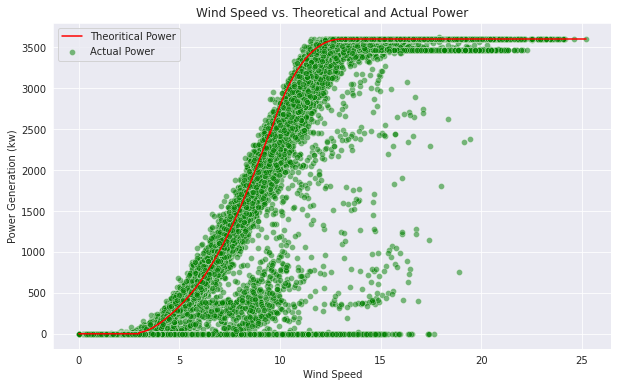

In [99]:
# Thoretical power vs. actual power
df_pow = pd.DataFrame()
df_pow['wind_speed'] = df.select('wind speed (m/s)').toPandas().to_numpy().reshape(-1)
df_pow['pow_theory'] = df.select('theoretical_power_curve (kwh)').toPandas().to_numpy().reshape(-1)
df_pow['pow_actual'] = df.select('lv activepower (kw)').toPandas().to_numpy().reshape(-1)

plt.figure(figsize=(10,6))
sns.scatterplot(x='wind_speed', y='pow_actual', color='green', label='Actual Power', alpha=0.5, data = df_pow)
sns.lineplot(x='wind_speed', y='pow_theory', color='red', label='Theoritical Power', data = df_pow)
plt.title('Wind Speed vs. Theoretical and Actual Power')
plt.xlabel('Wind Speed')
plt.ylabel('Power Generation (kw)')
plt.legend()
plt.show()



*   Generally, the theoretical power curve fits the acutal generated power well
*   At lower wind speeds (< 3 m/s), the theoretical power as well as the actual power is zero.
*   There are some points of zero power generated even at higher wind speeds > 3 m/s (The theoretical power significantly high at these points).





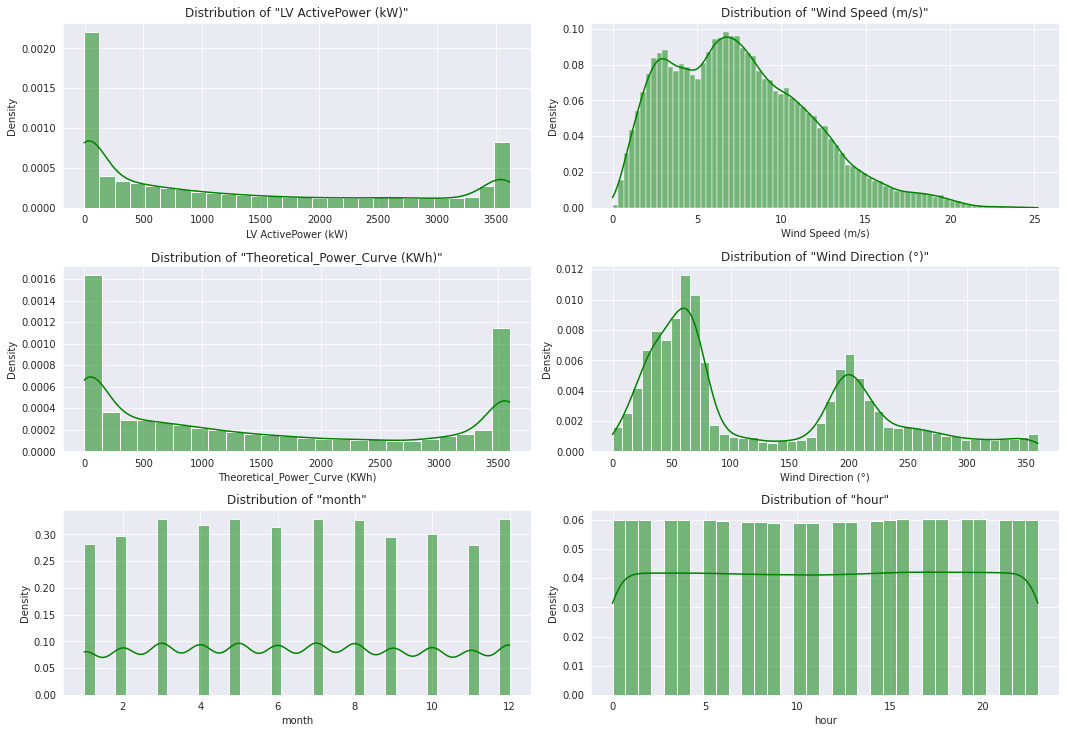

In [100]:
# Distribution of numerical features
num_df = df.toPandas().select_dtypes(exclude = 'object')
num_features = num_df.columns
plt.figure(figsize = (15,20))
i = 1
for col in num_features:
  plt.subplot(len(num_features), 2 , i)
  sns.histplot(data = num_df, x = col, stat = 'density', kde = True, color = 'g')
  plt.title('Distribution of "%s"' %(col))
  i += 1
plt.tight_layout()  



*   The distribution of power generated (lv ActivePower) is mostly uniformly distributed except at the extreme ends.
*   Wind Speed has a bell curve distribution with the data being right skewed indicating some rare occureneces of high wind speeds.

*   Approximately uniform distribution of Theoretical power (similar to Actual power)
*   Wind direction has a bimodal distribution. Mostly wind blows in the direction of wither 50 degree or 200 degrees.







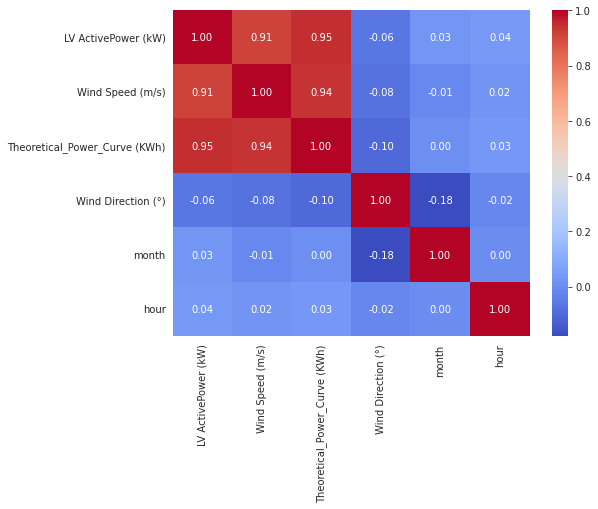

In [101]:
# Correlation among the variables
plt.figure(figsize = (8,6))
sns.heatmap(num_df.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()



*   Power generated is highly dependent on wind speed but has no correlation with the wind's direction.



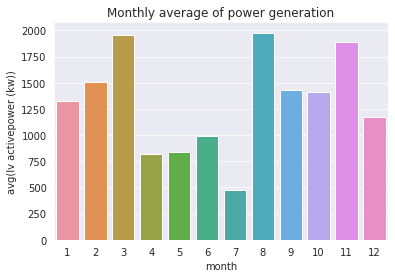

In [102]:
# Average Power generation in a month
pow_month = df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x = 'month', y = 'avg(lv activepower (kw))', data = pow_month)
plt.title('Monthly average of power generation');

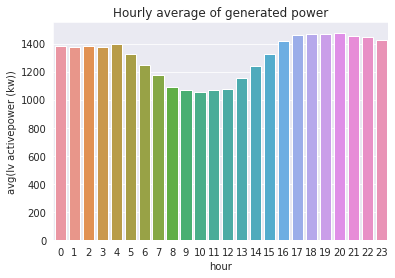

In [103]:
# Hourly average of generated power
pow_hour = df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x = 'hour', y = 'avg(lv activepower (kw))', data = pow_hour)
plt.title('Hourly average of generated power');

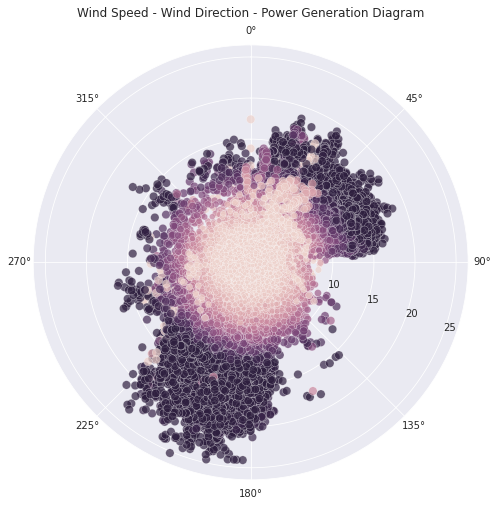

In [104]:
# Power generation for different wind directions and wind speeds
import math

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# Inside circles are the wind speed and marker color and size represents the amount of power production
x = [math.radians(x) for x in df.select('wind direction (°)').toPandas().to_numpy().reshape(-1)]
sns.scatterplot(data = df_pow, x = x, y = 'wind_speed', size = 'pow_theory',
                hue = 'pow_actual', alpha=0.7, legend=None)
# Setting the polar diagram's top represents the North 
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Power Generation Diagram')
plt.ylabel(None);

No. of records where both theoretical and actual power is zero = 7284
No. of records where theroretical power is non zero but actual power is zero with Wind speed > 3 m/s = 3497
------------------------------------------------------------------------------------------------------------------------


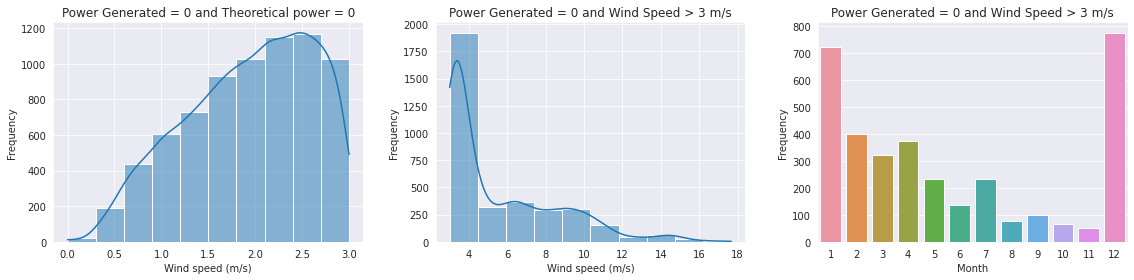

In [105]:
# Zero power analysis : wind speed threshold value for zero theorical power?

plt.figure(figsize = (16,4))

# Filter the big data where the real and theoritical power == 0
pow_theo_zero = df.filter((df['LV ActivePower (kW)'] == 0) & (df['Theoretical_Power_Curve (KWh)'] == 0)).toPandas()
s1 = pow_theo_zero.shape[0]

plt.subplot(1,3,1)
sns.histplot(data = pow_theo_zero, x = 'Wind Speed (m/s)', stat = 'count', kde = True, bins = 10)
plt.title('Power Generated = 0 and Theoretical power = 0')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency');

# Power Generated == 0 and Wind Speed > 3 m/s
pow_theo_zero = df.filter((df['LV ActivePower (kW)'] == 0) & 
                          (df['Theoretical_Power_Curve (KWh)'] != 0) & 
                          (df['Wind Speed (m/s)'] > 3)).toPandas()
s2 = pow_theo_zero.shape[0]

plt.subplot(1,3,2)
sns.histplot(data = pow_theo_zero, x = 'Wind Speed (m/s)', stat = 'count', kde = True, bins = 10)
plt.title('Power Generated = 0 and Wind Speed > 3 m/s')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')

plt.subplot(1,3,3)
sns.countplot(x = 'month', data = pow_theo_zero)
plt.title('Power Generated = 0 and Wind Speed > 3 m/s')
plt.xlabel('Month')
plt.ylabel('Frequency')

plt.tight_layout()

print(f"No. of records where both theoretical and actual power is zero = {s1}")
print(f"No. of records where theroretical power is non zero but actual power is zero with Wind speed > 3 m/s = {s2}")
print("---"*40)

We will remove the records where theoretical power is zero.

In [106]:
df = df.filter(
    ~(
    (df['LV ActivePower (kW)'] == 0) & 
    (df['Theoretical_Power_Curve (KWh)'] != 0) & 
    (df['Wind Speed (m/s)'] > 3)
    )
)

In [107]:
df.toPandas().columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'month', 'hour'],
      dtype='object')

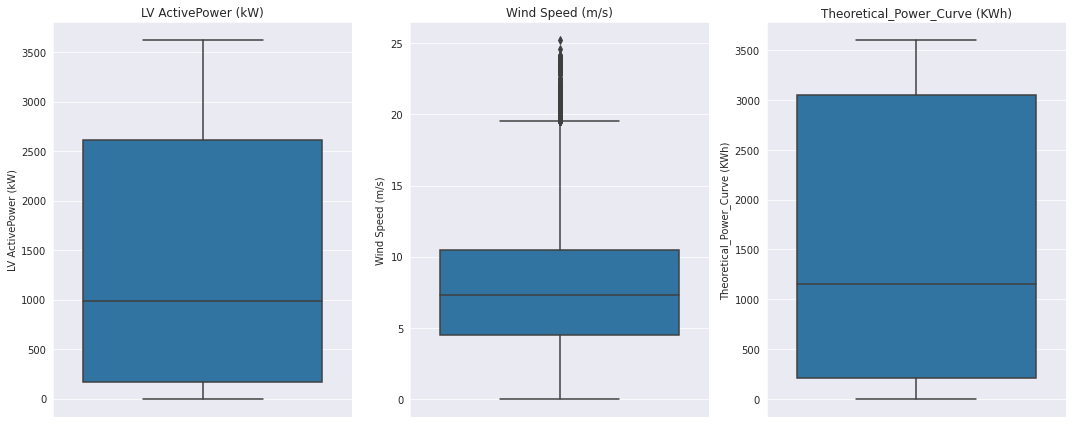

In [108]:
# Outlier detection : We will use IQR method to detect the outliers

vars = ['LV ActivePower (kW)', 'Wind Speed (m/s)','Theoretical_Power_Curve (KWh)']
vars_df = df.select(vars).toPandas()

plt.figure(figsize = (15,6))

i = 1
for var in vars:
  plt.subplot(1,3,i)
  sns.boxplot(y = var, data = vars_df)
  plt.title(var)
  i += 1
plt.tight_layout()  



*   Wind speed has outliers on the higher end.



In [109]:
# Outlier analysis

q1 = vars_df['Wind Speed (m/s)'].quantile(q = 0.25)
q3 = vars_df['Wind Speed (m/s)'].quantile(q = 0.75)
iqr = q3 - q1

print("First quartile = %.2f, Third quartile = %.2f, IQR = %.2f" %(q1,q3,iqr))

df_outliers = vars_df[(vars_df['Wind Speed (m/s)'] > (q3 + 1.5*iqr)) | (vars_df['Wind Speed (m/s)'] < (q1 - 1.5*iqr))]
print("NO. of unusual datapoints in Wind Speed = %d" %(df_outliers.shape[0]))

First quartile = 4.46, Third quartile = 10.48, IQR = 6.02
NO. of unusual datapoints in Wind Speed = 407


* Wind speed > 19 m/s has rare occurences, only 407 such instances present in the dataset

* Average power for wind speed >= 19 m/s

In [110]:
df.select('wind speed (m/s)', 'lv activepower (kw)').filter(df['wind speed (m/s)'] >= 19).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



In [111]:
from pyspark.sql.functions import col, when
df = df.withColumn('wind speed (m/s)', 
                    when(col('wind speed (m/s)') > 19.447, 19).otherwise(col('wind speed (m/s)')))
df.count()

47033

Key Takeaways:

* We saw from the graph that in March, August and November, the average power production is higher.

* The average power production is higher daily between 16:00 and 24:00.

* The power production is higher when the wind blows from the directions between 000-090 and 180-225 degrees.


## Data Preparation for ML Algorithms

The significant variables for making the predictions are


*   Wind speed
*   Wind direction
*   Month
*   Hour

In [113]:
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
df = df.withColumn('label', df['lv activepower (kw)'])

# features to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'Wind Direction (°)']

# Preparing the independent variables (Features)
vectorizer = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_dm = vectorizer.transform(df)

# Combining features and label column
dm_df = vec_dm.select('features', 'label')
dm_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



In [114]:
# train test split
df_train, df_val = dm_df.randomSplit([0.8, 0.2])
df_train.count(), df_val.count()

(37556, 9477)

## GBT Regression

In [115]:
from pyspark.ml.regression import GBTRegressor

gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Fit the model with training data
gbm_model = gbm.fit(df_train)

# Making predictions on validation set
y_pred = gbm_model.transform(df_val)

y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|0.3320847188352987|
|             0.0| 17.17948749401888|
|244.259399414062|224.53410438181885|
|232.675399780273|305.10869726576067|
|248.946304321289|305.10869726576067|
|296.469909667968| 322.6101667589759|
|359.028289794921|426.64046680774237|
|402.391998291015| 510.2271967902894|
|574.656921386718| 514.9229390246775|
|659.148620605468| 514.9229390246775|
|492.112487792968| 602.3864795965458|
|791.083618164062| 731.9658435568588|
|837.063720703125| 745.1341517329598|
|845.205017089843| 733.7235786715205|
|989.507690429687| 832.6198047846942|
|949.494323730468| 887.3348664006994|
| 1121.1669921875| 965.7853335356729|
|1182.03503417968| 1126.759312759812|
|1878.79504394531|1891.6057719147427|
| 2044.2080078125| 1958.251603190879|
+----------------+------------------+
only showing top 20 rows



### Regression metrics

In [116]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

# r-squared
r2 =  evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'})

# Mean Absolute Error
mae =  evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'})

# Root Mean Squared Error
rmse =  evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'})

print('R2 SCORE : %.2f%%' %(r2*100))
print('MAE      : %.3f' %(mae))
print('RMSE     : %.3f' %(rmse))

R2 SCORE : 97.95%
MAE      : 85.377
RMSE     : 186.351


### Comparing Theoretical Power, Actual Power and Predicted Power

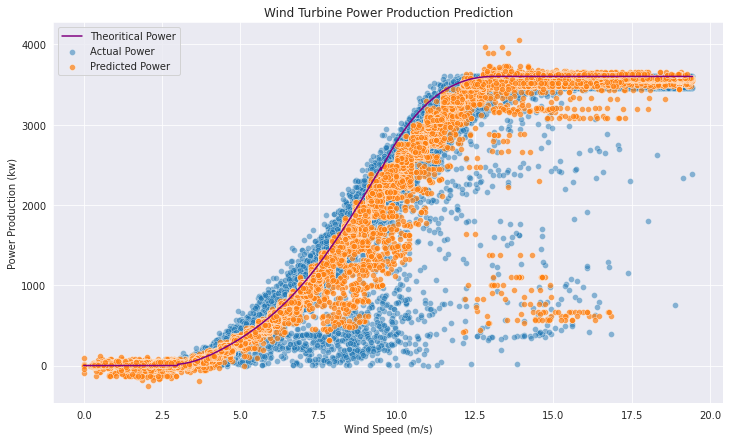

In [121]:
df = df.withColumn('label', df['lv activepower (kw)'])

variables = ['month', 'hour', 'wind speed (m/s)', 'Wind Direction (°)']
vectorizer = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorizer.transform(df)

vec_df = vec_df.select('features', 'label')

preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Concatenating the dataframes
dfs = [df[['Wind Speed (m/s)', 'theoretical_power_curve (kwh)']].toPandas(), preds_df]
power = pd.concat(dfs, axis=1)

# Visualizing Actual, theoretical and predicted power production
plt.figure(figsize=(12,7))
sns.scatterplot(x='Wind Speed (m/s)', y='label',alpha=0.5, label= 'Actual Power', data=power)
sns.scatterplot(x='Wind Speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=power)
sns.lineplot(x='Wind Speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=power)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();